# Kopp et al 2021 Evaluation 
**Authorship:**
Adam Klie, *08/12/2022*
***
**Description:**
Notebook to perform a brief evaluation of trained models on the Kopp21 et al dataset.
***

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import glob
import logging
import torch
import numpy as np
import pandas as pd
import eugene as eu
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


In [2]:
# Configure EUGENe 
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene/kopp21"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/kopp21"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/kopp21"
eu.settings.config_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/configs/kopp21"
eu.settings.figure_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/figures/kopp21"
eu.settings.verbosity = logging.ERROR

# Load in the test `SeqData`(s)

In [4]:
# Load in the training data that's been predicted on
sdata_test = eu.dl.read_h5sd(
    filename=os.path.join(eu.settings.output_dir, "jund_test_predictions_all.h5sd")
)
sdata_test

SeqData object with = 64309 seqs
seqs = (64309,)
names = (64309,)
rev_seqs = None
ohe_seqs = (64309, 4, 500)
ohe_rev_seqs = (64309, 4, 500)
seqs_annot: 'Kopp21CNN_trial_1_target_predictions', 'Kopp21CNN_trial_2_target_predictions', 'Kopp21CNN_trial_3_target_predictions', 'Kopp21CNN_trial_4_target_predictions', 'Kopp21CNN_trial_5_target_predictions', 'chr', 'dsCNN_trial_1_target_predictions', 'dsCNN_trial_2_target_predictions', 'dsCNN_trial_3_target_predictions', 'dsCNN_trial_4_target_predictions', 'dsCNN_trial_5_target_predictions', 'dsFCN_trial_1_target_predictions', 'dsFCN_trial_2_target_predictions', 'dsFCN_trial_3_target_predictions', 'dsFCN_trial_4_target_predictions', 'dsFCN_trial_5_target_predictions', 'dsHybrid_trial_1_target_predictions', 'dsHybrid_trial_2_target_predictions', 'dsHybrid_trial_3_target_predictions', 'dsHybrid_trial_4_target_predictions', 'dsHybrid_trial_5_target_predictions', 'end', 'start', 'target', 'train_test'
pos_annot: None
seqsm: None
uns: None

# Generate performance figures

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


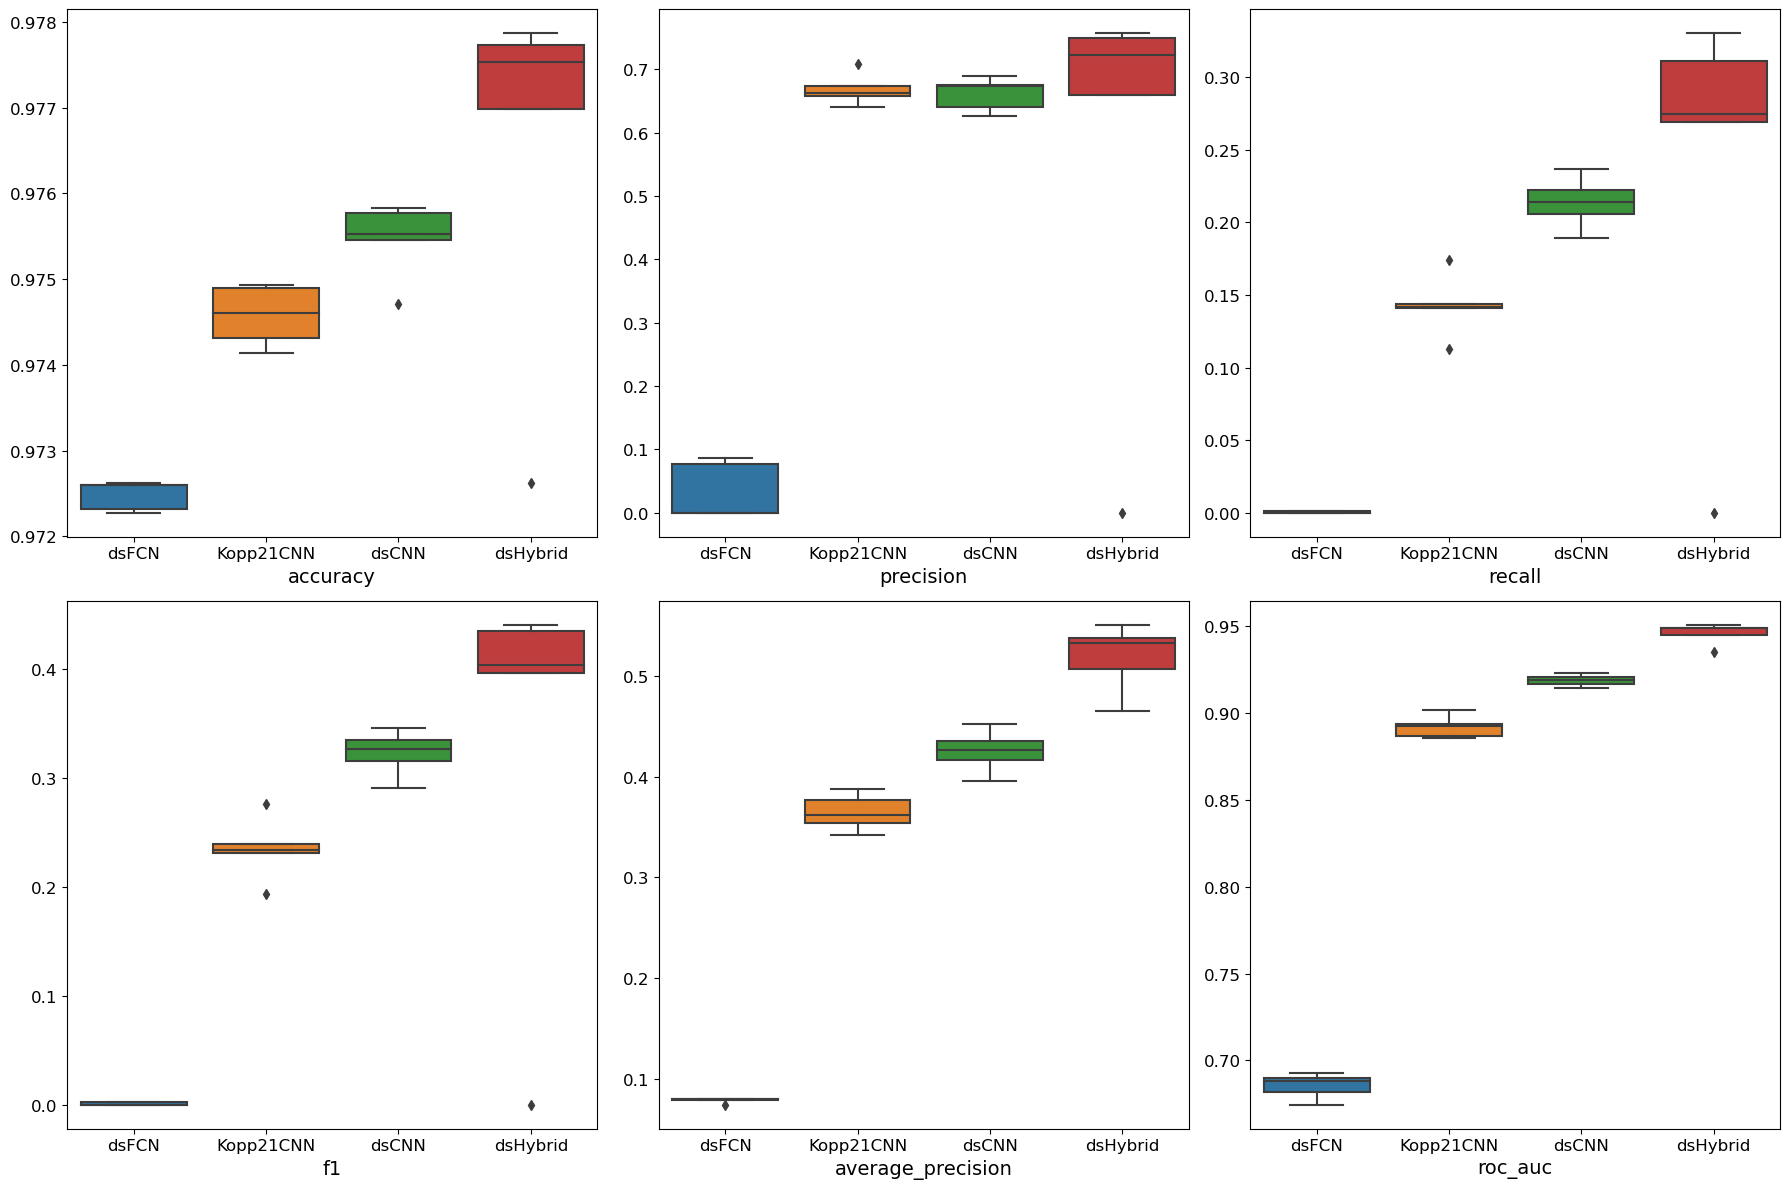

In [8]:
# Summarize performance across models for a metric
model_scores = eu.pl.performance_summary(
    sdata_test,
    target="target",
    prediction_groups=["Kopp21CNN"]*5 + ["dsCNN"]*5 + ["dsFCN"]*5 + ["dsHybrid"]*5, 
    order=["dsFCN", "Kopp21CNN", "dsCNN", "dsHybrid"],
    metrics=["accuracy", "precision", "recall", "f1", "average_precision", "roc_auc"],
    figsize=(6, 6)
)
plt.savefig(os.path.join(eu.settings.figure_dir, "jund_performance_summary.pdf"), bbox_inches="tight")
plt.show()

<AxesSubplot:ylabel='auPRC'>

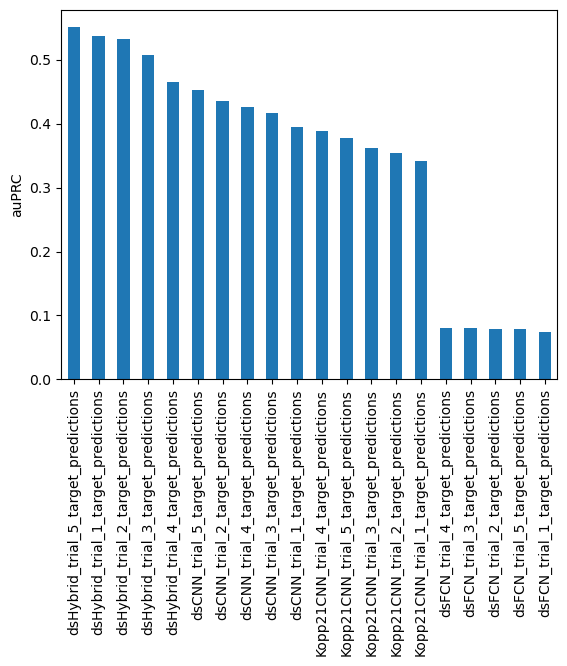

In [9]:
# Identify the best model from returned model scores
auprc_sorted = model_scores["average_precision"].sort_values(ascending=False)
auprc_sorted.plot(kind="bar", ylabel="auPRC")

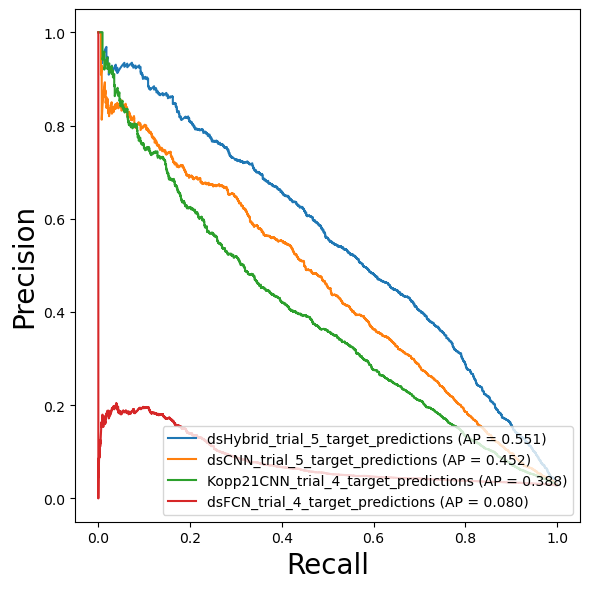

In [10]:
# Plot the performances across species for the best model
model_scores["model_type"] = [model.split("_")[0] for model in model_scores.index]
best_preds = model_scores.sort_values(by="average_precision", ascending=False).groupby("model_type").head(1).index
eu.pl.auprc(
    sdata_test,
    targets=["target"]*4, 
    predictions=best_preds,
    labels=best_preds,
    save=os.path.join(eu.settings.figure_dir, "jund_best_model_auprc.pdf")
)
plt.show()

# Seq track visualizations

In [17]:
sdata_test = eu.dl.read_h5sd(os.path.join(eu.settings.output_dir, "jund_test_predictions_and_interpretations.h5sd"))

In [20]:
sdata_test.uns["GradientSHAP_forward_imps"][0].T

array([[ 0.0337818 ,  0.        ,  0.        ,  0.        ],
       [-0.00618998,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.00513286,  0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        ,  0.00254058],
       [ 0.        ,  0.        , -0.0010674 ,  0.        ],
       [ 0.00013264,  0.        ,  0.        ,  0.        ]])

In [21]:
sdata_test.ohe_seqs[0].T

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [1, 0, 0, 0]], dtype=int8)

In [22]:
sdata_test.ohe_rev_seqs[0].T

array([[0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=int8)

In [23]:
sdata_test.uns["GradientSHAP_reverse_imps"][0].T

array([[ 0.        ,  0.        ,  0.        ,  0.00075188],
       [ 0.        , -0.00093702,  0.        ,  0.        ],
       [ 0.00047787,  0.        ,  0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        , -0.02777856,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.01663651],
       [ 0.        ,  0.        ,  0.        , -0.00764115]])

In [ ]:
sdata_test.uns["GradientSHAP_forward_imps"][0]

In [27]:
top2 = sdata_test["dsHybrid_trial_5_target_predictions"].sort_values(ascending=False).iloc[:2].index

In [29]:
top2_idx = np.argsort(sdata_test["dsHybrid_trial_5_target_predictions"].values)[::-1][:2]

In [30]:
np.where(np.sum(sdata_test.uns["GradientSHAP_forward_imps"][top2_idx], axis=1) > 0.1)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([ 77,  79,  80,  81,  82,  83,  84,  85,  86, 321, 323, 325, 327,
        216, 224, 270, 272, 273, 274, 275, 277]))

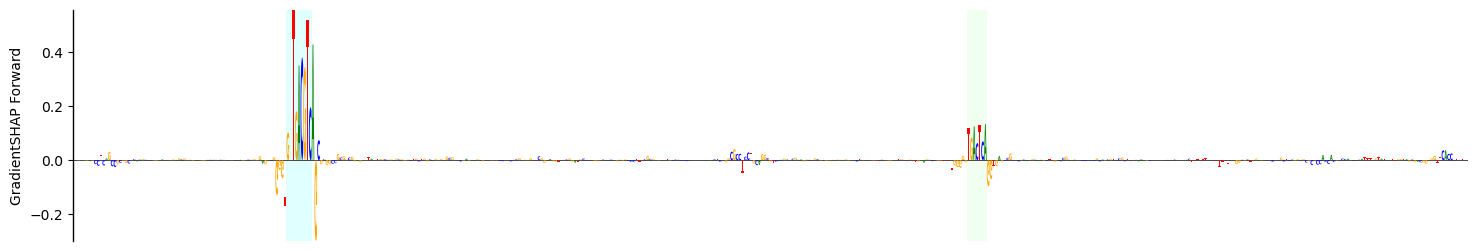

In [44]:
eu.pl.lm_seq_track(
    sdata_test,
    seq_id=top2[0],
    uns_key="GradientSHAP_forward_imps",
    ylabel="GradientSHAP Forward",
    figsize=(18, 3),
    highlights=[(77,85), (321, 327)],
    highlight_colors = ["lightcyan", "honeydew"],
    save=os.path.join(eu.settings.figure_dir, "jund_best_Hybrid_model_GradientSHAP_forward_imps_top1.pdf")
)

In [45]:
np.where(np.sum(sdata_test.uns["GradientSHAP_reverse_imps"][top2_idx], axis=1) > 0.1)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([172, 173, 174, 176, 177, 178, 413, 414, 415, 416, 417, 418, 419,
        420, 220, 222, 223, 224, 225, 226, 227, 229]))

In [ ]:
np.where(np.sum(sdata_test.uns["GradientSHAP_reverse_imps"][top2_idx], axis=1) > 0.1)

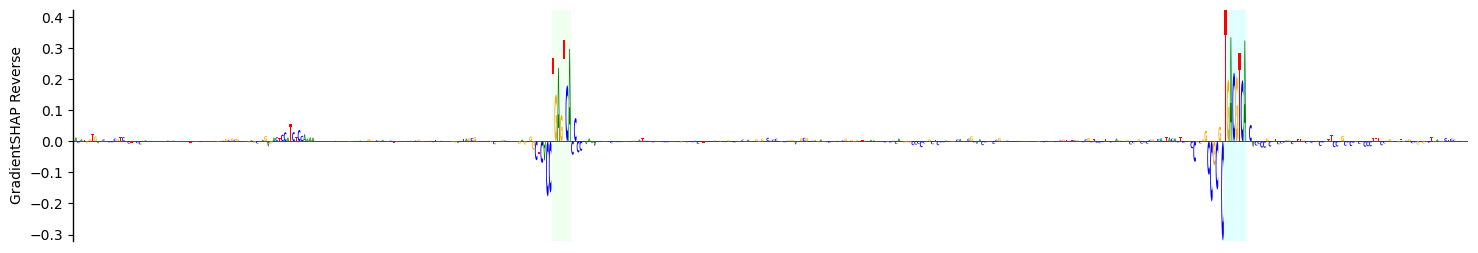

In [50]:
eu.pl.lm_seq_track(
    sdata_test,
    seq_id=top2[0],
    uns_key="GradientSHAP_reverse_imps",
    ylabel="GradientSHAP Reverse",
    figsize=(18, 3),
    highlights=[(172,178), (413, 420)],
    highlight_colors = ["honeydew", "lightcyan"],
    save=os.path.join(eu.settings.figure_dir, "jund_best_Hybrid_model_GradientSHAP_reverse_imps_top1.pdf")
)

In [54]:
np.where(np.sum(sdata_test.uns["InputXGradient_forward_imps"][top2_idx], axis=1) > 0.05)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([ 79,  84,  86, 322, 323, 325, 326, 327, 421, 448, 451, 468, 469,
        471, 473, 476, 480, 484, 490, 270, 272, 273, 275, 277, 374, 378,
        382, 391, 434, 435, 436, 441, 447, 474, 483, 484, 486, 487]))

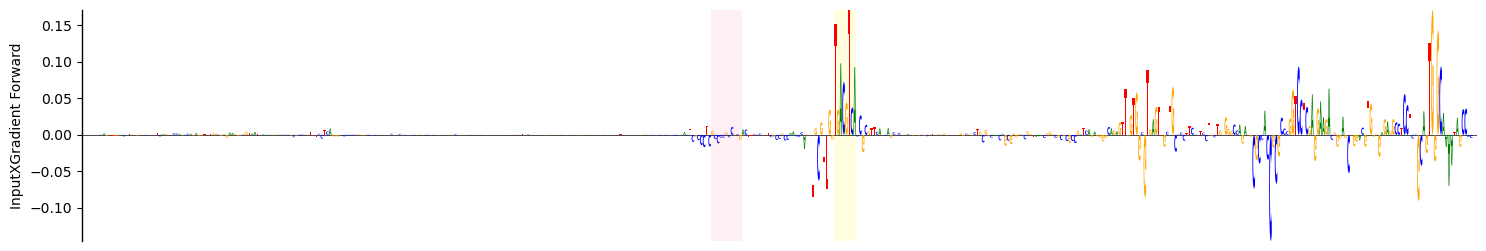

In [68]:
eu.pl.lm_seq_track(
    sdata_test,
    seq_id=top2[1],
    uns_key="InputXGradient_forward_imps",
    ylabel="InputXGradient Forward",
    figsize=(18, 3),
    highlights=[(226, 236), (270,277)],
    highlight_colors = ["lavenderblush", "lightyellow"],
    save=os.path.join(eu.settings.figure_dir, "jund_best_Hybrid_model_InputXGradient_forward_imps_top2.pdf")
)

In [62]:
np.where(np.sum(sdata_test.uns["InputXGradient_reverse_imps"][top2_idx], axis=1) > 0.025)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([176, 178, 408, 409, 410, 412, 423, 451, 455, 467, 468, 479, 496,
        498, 499, 264, 265, 266, 268, 269, 270, 272, 273, 274, 281, 374,
        441, 445, 448, 453, 489]))

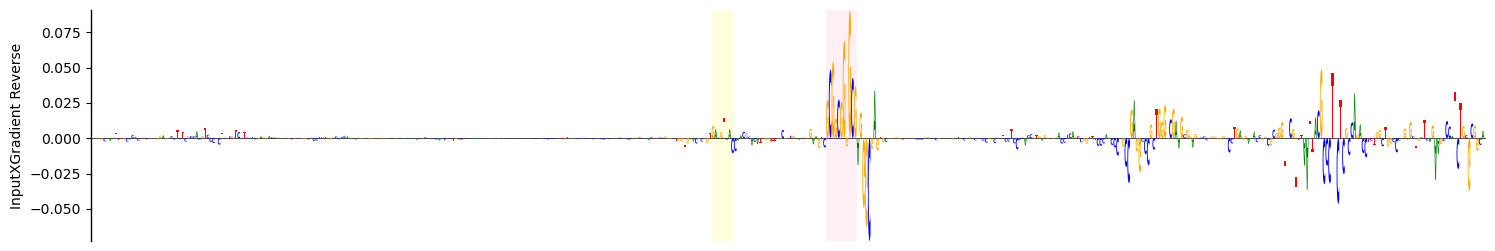

In [69]:
eu.pl.lm_seq_track(
    sdata_test,
    seq_id=top2[1],
    uns_key="InputXGradient_reverse_imps",
    ylabel="InputXGradient Reverse",
    figsize=(18, 3),
    highlights=[(223, 230), (264,274)],
    highlight_colors = ["lightyellow", "lavenderblush"],
    save=os.path.join(eu.settings.figure_dir, "jund_best_Hybrid_model_InputXGradient_reverse_imps_top2.pdf")
) 

# TomTom results

In [70]:
res = pd.read_csv(os.path.join(eu.settings.output_dir, "jund_best_Hybrid_model_filters_tomtom.tsv"), sep="\t", comment="#")

In [85]:
res_sig = res[res["q-value"] < 0.05].sort_values(by="q-value")

In [91]:
res_sig[res_sig["Target_ID"] == "MA0535.1"]

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
247,filter8,MA0535.1,2,0.000036,0.069842,0.006408,13,CCCCCCCCCCCCCCA,CAGGCGCCGCCGCCG,+
877,filter31,MA0535.1,0,0.000726,1.419280,0.036082,15,CCGCCCCCGCGGCCC,CAGGCGCCGCCGCCG,+


In [87]:
res_sig.value_counts("Target_ID").iloc[:25]

Target_ID
MA0740.2    3
MA1893.1    3
MA0079.5    3
MA0516.3    3
MA1511.2    3
MA0685.2    3
MA1961.1    3
MA1890.1    3
MA1892.1    3
MA0742.2    3
MA0522.3    2
MA1713.1    2
MA0535.1    2
MA0597.2    2
MA1653.1    2
MA0746.2    2
MA1818.1    2
MA0753.2    2
MA1650.1    2
MA1627.1    2
MA1102.2    2
MA0975.1    2
MA0976.2    2
MA0979.1    2
MA1513.1    2
dtype: int64

In [16]:
res_sig.groupby("Query_ID").head(1)

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
355,filter11,MA1929.1,0,4.502470e-11,8.806840e-08,8.783220e-08,15,GAGCGCCACCTAGTG,TAGCGCCCCCTGGTGGCCACAGCTGGAACTGCAG,-
479,filter18,MA0139.1,4,6.323540e-11,1.236890e-07,2.469040e-07,15,GCCCCCTGGTGGCCA,TAGCGCCCCCTGGTGGCCA,-
755,filter29,MA1141.1,-1,1.449700e-08,2.835600e-05,5.599170e-05,13,ACTATGACTCATCCC,CGATGACTCATCC,-
805,filter31,MA1817.1,0,1.181440e-07,2.310910e-04,4.430420e-04,13,CCGCCCCCGCGGCCC,CCGCCGCCGCCGC,+
659,filter26,MA0922.1,-6,1.968470e-07,3.850330e-04,7.464120e-04,9,TAATACTTATGTAAT,TTATGTAAT,-
229,filter8,MA1819.1,0,5.516790e-07,1.079080e-03,1.039550e-03,12,CCCCCCCCCCCCCCA,GCCGCCGCCGCC,+
715,filter27,MA1201.1,-6,8.148070e-07,1.593760e-03,3.187520e-03,7,ACACAAGATGATGGC,GATGATG,-
421,filter15,MA0290.1,4,4.181040e-06,8.178110e-03,1.609160e-02,15,GCAGCGCGCGCTATT,AAAAGCCGCGGGCGGGATT,+
84,filter1,MA1961.1,0,2.760690e-05,5.399910e-02,3.408070e-02,12,GCCCAGCCCCACCCC,CCCCCGCCCCCC,-
794,filter30,MA1121.1,-2,9.295340e-06,1.818170e-02,3.636340e-02,13,CTCCACATTCCTGTC,TCACATTCCAGCC,+


---

# Scratch